In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, fourier_gaussian
import matplotlib.pyplot as plt
from scipy import signal
import scipy.stats as stats
import time

In [2]:
def input_pk(k):
    return norm * (k/kpiv)**-beta_spec * (np.exp(-1/(Lcut*k)**2))**0.5*np.exp(-(k*Ldis)**2)**0.5

In [3]:
Nx, Ny = 31, 41 # Number of pixel
reso = 5.0      # Resolution in arcsec
Nz = 20
rlos = 10.0
mapscale = 1    # Increase the map size by this factor for aliasing purpose

Lcut = 100.0        # Injection cut in arcsec
Ldis = 50.0        # Injection cut in arcsec
beta_spec = 11.0/3  # Spectral index for the modelign
kpiv = 0.2          # k at which Pk is normalized
norm = 1            # Normalization of Pk

In [4]:
# Number of pixels to add on each side to avoid aliasing effects
Nadd_x = int((Nx*mapscale-Nx)/2)
Nadd_y = int((Ny*mapscale-Ny)/2)
Nadd_z = int((Nz*mapscale-Nz)/2)
Nx_add, Ny_add, Nz_add = int(Nx + 2*Nadd_x), int(Ny + 2*Nadd_y), int(Nz + 2*Nadd_z)

print(Nadd_x, Nadd_y, Nadd_z, Nx_add, Ny_add, Nz_add)

0 0 0 31 41 20


In [5]:
# Bining and k definition
k_x = np.fft.fftfreq(Nx, reso)
k_y = np.fft.fftfreq(Ny, reso)
k_z = np.fft.fftfreq(Nz, rlos)
k2d_x, k2d_y = np.meshgrid(k_x, k_y, indexing='ij')
k2d = np.sqrt(k2d_x**2 + k2d_y**2)
k3d_x, k3d_y, k3d_z = np.meshgrid(k_x, k_y, k_z, indexing='ij')
k3d = np.sqrt(k3d_x**2 + k3d_y**2 + k3d_z**2)

k_x_add = np.fft.fftfreq(Nx_add, reso)
k_y_add = np.fft.fftfreq(Ny_add, reso)
k_z_add = np.fft.fftfreq(Nz_add, rlos)
k2d_x_add, k2d_y_add = np.meshgrid(k_x_add, k_y_add, indexing='ij')
k2d_add = np.sqrt(k2d_x_add**2 + k2d_y_add**2)
k3d_x_add, k3d_y_add, k3d_z_add = np.meshgrid(k_x_add, k_y_add, k_z_add, indexing='ij')
k3d_add = np.sqrt(k3d_x_add**2 + k3d_y_add**2 + k3d_z_add**2)

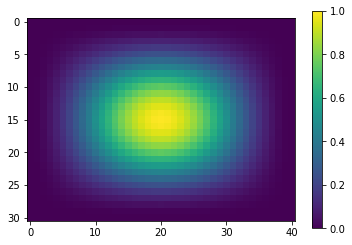

In [6]:
window = signal.hann(Nx)[:, np.newaxis] * signal.hann(Ny)
plt.imshow(window)
plt.colorbar()

In [7]:
Nmc = 300
Pk_1d_mc  = np.zeros((Nmc, Nx*Ny))
Pk_2d_mc = np.zeros((Nmc, Nx, Ny))

for imap in range(Nmc):
    Pk_in = input_pk(k3d_add)
    Pk_in[k3d_add == 0] = 0
    image = np.random.normal(0, 1, (Nx_add, Ny_add, Nz_add))
    fftfield = np.fft.fftn(image) * np.sqrt(Pk_in / (reso**2*rlos))
    image = np.real(np.fft.ifftn(fftfield))
    image = image[Nadd_x:Nx_add-Nadd_x, Nadd_y:Ny_add-Nadd_y, Nadd_z:Nz_add-Nadd_z]
    image = np.sum(image, axis=2)
    '''
    Pk_in = input_pk(k2d_add)
    Pk_in[k2d_add == 0] = 0
    image = np.random.normal(0, 1, (Nx_add, Ny_add))
    fftfield = np.fft.fftn(image) * np.sqrt(Pk_in / (reso**2))
    image = np.real(np.fft.ifftn(fftfield))
    image = image[Nadd_x:Nx_add-Nadd_x, Nadd_y:Ny_add-Nadd_y]
    '''
    #image = image * window**2 * Nx*Ny/np.sum(window)
    
    fft_image = np.fft.fftn(image)
    Pk_1d_mc[imap,:]   = (np.abs(fft_image)**2).flatten() * reso**2 / (Nx*Ny)
    Pk_2d_mc[imap,:,:] = np.abs(fft_image)**2 * reso**2 / (Nx*Ny)

WF = Nz/rlos
#WF = 1

Pk_1d = np.mean(Pk_1d_mc, axis=0) / WF
Pk_2d = np.mean(Pk_2d_mc, axis=0) / WF

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


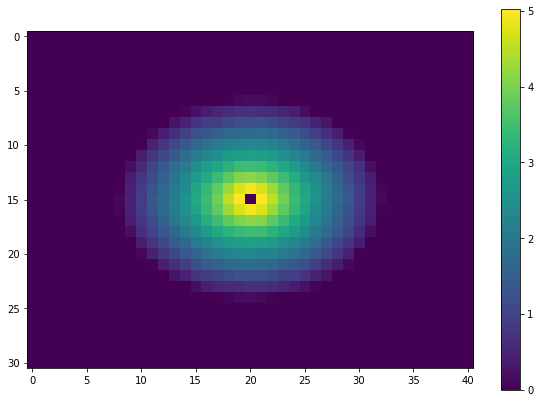

In [8]:
plt.figure(figsize=(10,7))
plt.imshow(np.log10(np.fft.fftshift(Pk_2d)), vmin=0)
plt.colorbar()

(4.418329269994602e-28, 209737.3319108301)

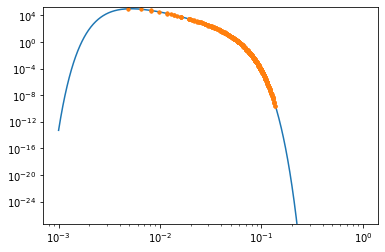

In [9]:
k=np.logspace(-3,0, 1000)
pk_in = input_pk(k)
plt.loglog(k, pk_in)
plt.loglog(k2d.flatten(), Pk_1d, marker='.', ls='')
plt.ylim(np.amin(Pk_1d)/2,np.amax(Pk_1d)*2)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


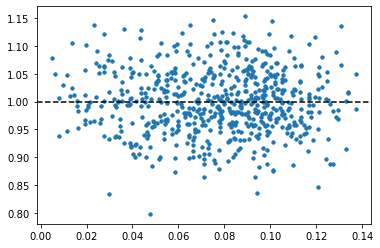

In [10]:
pk_in_itpl = input_pk(k2d.flatten())
plt.plot(k2d.flatten(), Pk_1d/pk_in_itpl, marker='.', ls='')
plt.axhline(1, ls='--', color='k')